In [1]:
%matplotlib inline
from construct import *
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Construct structures defining the DSLWP-B telemetry.

In [2]:
TMPrimaryHeader = BitStruct('transfer_frame_version_number' / BitsInteger(2),
                            'spacecraft_id' / BitsInteger(10),
                            'virtual_channel_id' / BitsInteger(3),
                            'ocf_flag' / Flag,
                            'master_channel_frame_count' / BitsInteger(8),
                            'virtual_channel_frame_count' / BitsInteger(8),
                            'first_header_pointer' / BitsInteger(8))

SpacePacketPrimaryHeader = BitStruct('ccsds_version' / BitsInteger(3),
                                     'packet_type' / BitsInteger(1),
                                     'secondary_header_flag' / Flag,
                                     'AP_ID' / BitsInteger(11),
                                     'sequence_flags' / BitsInteger(2),
                                     'packet_sequence_count_or_name' / BitsInteger(14),
                                     'data_length' / BitsInteger(16))

class AffineAdapter(Adapter):
    def __init__(self, c, a, *args, **kwargs):
        self.c = c
        self.a = a
        return Adapter.__init__(self, *args, **kwargs)
    def _encode(self, obj, context, path = None):
        return int(round(obj * self.c + self.a))
    def _decode(self, obj, context, path = None):
        return (float(obj) - self.a)/ self.c

class LinearAdapter(AffineAdapter):
    def __init__(self, c, *args, **kwargs):
        return AffineAdapter.__init__(self, c, 0, *args, **kwargs)

Current = LinearAdapter(1/3.2, Int8ub)
Voltage = LinearAdapter(1/0.16, Int8ub)

class RSSIAdapter(Adapter):
    def _encode(self, obj, context, path = None):
        obj.rssi_asm = int(round((obj.rssi_asm + 174 - obj.gain_agc)*10))
        obj.rssi_channel = int(round((obj.rssi_channel + 174 - obj.gain_agc)*10))
        obj.rssi_7021 = int(round((obj.rssi_channel + 174 - obj.gain_agc)*2))
        return obj
    def _decode(self, obj, context, path = None):
        obj.rssi_asm = -174 + obj.rssi_asm/10 + obj.gain_agc
        obj.rssi_channel = -174 + obj.rssi_channel/10 + obj.gain_agc
        obj.rssi_7021 = -174 + obj.rssi_7021 * 0.5 + obj.gain_agc
        return obj

HKUV = RSSIAdapter(Struct(
    'config' / Int8ub,
    'flag_rx' / Int8ub,
    'tx_gain' / Int8ub,
    'tx_modulation' / Int8ub,
    'flag_tx' / Int8ub,
    'flag_7021' / Int8ub,
    'n_cmd_buf' / Int8ub,
    'n_cmd_dropped' / Int8ub,
    'i_bus_rx' / Current,
    'u_bus_rx' / Voltage,
    'i_bus_tx' / Current,
    'u_bus_tx' / Voltage,
    't_pa' / Int8sb,
    't_tx7021' / Int8sb,
    'n_jt4_tx' / Int8ub,
    'n_ham_rx' / Int8ub,
    'n_422_tx' / Int8ub,
    'n_422_rx' / Int8ub,
    'n_422_rx_pkg_err' / Int8ub,
    'n_422_rx_exe_err' / Int8ub,
    'cmd_422_last_rx' / Int8ub,
    'n_rf_tx' / Int8ub,
    'n_rf_tx_dropped' / Int8ub,
    'n_rf_rx' / Int8ub,
    'n_rf_rx_pkg_err' / Int8ub,
    'n_rf_rx_exe_err' / Int8ub,
    'n_rf_rx_fec_err' / Int8ub,
    'cmd_rf_last_rx' / Int8ub,
    'rsvd0' / Int8ub,
    'rsvd1' / Int8ub,
    'byte_corr' / Int8sb,
    'n_cmd' / Int8ub,
    'fc_asm' / LinearAdapter(32768/3.1416, Int16sb),
    'snr_asm' / LinearAdapter(256, Int16ub),
    'rssi_asm' / Int16ub,
    'rssi_channel' / Int16ub,
    'rssi_7021' / Int8ub,
    'gain_agc' / Mapping(Int8ub, {43.0: 0, 33.0: 1, 26.0: 2, 29.0: 4, 19.0: 5, 12.0: 6, 17.0: 8, 7.0: 9, 0.0: 10}),
    'rsvd15' / Int16sb,
    'seconds_since_epoch' / Int32ub,
    'cam_mode' / Int8ub,
    'cam_task_flag' / Int8ub,
    'cam_err_flag' / Int8ub,
    'cam_pic_len' / Int24ub,
    'cam_memory_id' / Int8ub,
    'jt4_task_flag' / Int8ub,
    'n_reset' / Int8ub,
    'flag_reset' / Int8ub,
    'flag_sys' / Int8ub,
    'n_dma_overflow' / Int8ub,
    'runtime' / LinearAdapter(1/0.004, Int32ub),
    'message' / Bytes(8)
))

StQ = LinearAdapter(2147483647, Int32sb)
FW = LinearAdapter(2, Int16sb)
Gyro = LinearAdapter(2147483647.0/400.0, Int32sb)

class QuadraticAdapter(Adapter):
    def _encode(self, obj, context, path = None):
        return np.sign(obj) * np.sqrt(np.abs(obj))
    def _decode(self, obj, context, path = None):
        return obj * np.abs(obj)


class WODTempAdapter(Adapter):
    def _encode(self, obj, context, path = None):
        raise Exception('Not implemented')
    def _decode(self, obj, context, path = None):
        return 1222415/(298.15*np.log(0.0244*obj/(25-0.0122*obj))+4100)-273.1
WODTemp = WODTempAdapter(Int16sb)

class WODTempThrustAdapter(Adapter):
    def _encode(self, obj, context, path = None):
        raise Exception('Not implemented')
    def _decode(self, obj, context, path = None):
        return -292525.18393*2/(-5289.94338+np.sqrt(5289.94338*5289.94338+4*292525.18393*(-4.77701-np.log(24.4*obj/(5-0.00244*obj)))))-273.15
WODTempThrust = WODTempThrustAdapter(Int16sb)

HKWOD = Struct(
    'seconds_since_epoch' / Int32ub,
    'n_cmd_exe' / Int8ub,
    'n_cmd_delay' / Int8ub,
    'this_wdt_timeout_count' / Int8ub,
    'that_wdt_timeout_count' / Int8ub,
    'sta_reset_count' / Int8ub,
    'stb_reset_count' / Int8ub,
    'ss_reset_count' / Int8ub,
    'is_reset_count' / Int8ub,
    'pl_task_err_flag' / Int8ub,
    'hsd_task_err_flag' / Int8ub,
    'tc_wdt_timeout_period' / LinearAdapter(12.0, Int8ub),
    'v_bus' / AffineAdapter(1/(0.00244*6.3894), 0.005/(0.00244*6.3894), Int16sb),
    'v_battery' / AffineAdapter(1/(0.00244*6.3617), -0.0318/(0.00244*6.3617), Int16sb),
    'i_solar_panel' / AffineAdapter(1/(0.00244*0.7171), -0.0768/(0.00244*0.7171), Int16sb),
    'i_load' / AffineAdapter(1/(0.00244*1.1442), 0.5254/(0.00244*1.1442), Int16sb),
    'i_bus' / AffineAdapter(1/(0.00244*0.8814), 9.4347/(0.00244*0.8814), Int16sb),
    'sw_flag' / Int8ub[4],
    'sta_q' / StQ[4],
    'sta_flag' / Int8ub,
    'stb_q' / StQ[4],
    'stb_flag' / Int8ub,
    'stc_q' / StQ[4],
    'stc_flag' / Int8ub,
    'ss_x' / Int32ub,
    'ss_y' / Int32ub,
    'ss_flag' / Int8ub,
    'fwx_rate' / FW,
    'fwx_cmd' / FW,
    'fwy_rate' / FW,
    'fwy_cmd' / FW,
    'fwz_rate' / FW,
    'fwz_cmd' / FW,
    'fws_rate' / FW,
    'fws_cmd' / FW,
    'gyro' / Gyro[3],
    'tank_pressure' / AffineAdapter(1/(0.00244*0.6528), 0.0330/(0.00244*0.6528), Int16sb),
    'aocs_period' / Int8ub,
    'error_q' / QuadraticAdapter(LinearAdapter(32767, Int16sb))[3],
    'error_w' / LinearAdapter(3.1415926/180, QuadraticAdapter(LinearAdapter(32767, Int16sb)))[3],
    'usb_agc' / LinearAdapter(256.0/5.0, Int8ub),
    'usb_rf_power' / LinearAdapter(256.0/5.0, Int8ub),
    'usb_temp2' / LinearAdapter(256.0/5.0, Int8ub),
    'usb_flag1' / Int8ub,
    'usb_flag2' / Int8ub,
    'usb_n_cmd' / Int8ub,
    'usb_n_direct_cmd' / Int8ub,
    'usb_n_inject_cmd' / Int8ub,
    'usb_n_inject_cmd_err' / Int8ub,
    'usb_n_sync' / Int8ub,
    't_pl' / WODTemp,
    't_hsd' / WODTemp,
    't_obc' / WODTemp,
    't_stb' / WODTemp,
    't_ss' / WODTemp,
    't_battery' / WODTemp,
    't_thrustor1a' / WODTempThrust,
    't_thrustor5a' / WODTempThrust,
    't_value1' / WODTemp,
    't_value5' / WODTemp,
    't_tube1' / WODTemp,
    't_tank' / WODTemp,
    'heater_flag' / Int8ub[5],
    'uva_flag_rx' / Int8ub,
    'uva_tx_gain' / Int8ub,
    'uva_tx_modulation' / Int8ub,
    'uva_flag_tx' / Int8ub,
    'uva_fc_asm' / LinearAdapter(32768/3.1416, Int16sb),
    'uva_snr_asm' / LinearAdapter(256, Int16ub),
    'uva_rssi_asm' / AffineAdapter(10, 10*(174-12), Int16ub),
    'uva_rssi_7021' / AffineAdapter(2, 2*(140-12), Int8ub),
    'uvb_flag_rx' / Int8ub,
    'uvb_tx_gain' / Int8ub,
    'uvb_tx_modulation' / Int8ub,
    'uvb_flag_tx' / Int8ub,
    'uvb_fc_asm' / LinearAdapter(32768/3.1416, Int16sb),
    'uvb_snr_asm' / LinearAdapter(256, Int16ub),
    'uvb_rssi_asm' / AffineAdapter(10, 10*(174-12), Int16ub),
    'uvb_rssi_7021' / AffineAdapter(2, 2*(140-12), Int8ub),
)

CfgUV = Struct(
    'dem_clk_divide' / Int8ub,
    'tx_frequency_deviation' / Int8ub,
    'tx_gain' / Int8ub,
    'turbo_rate' / Int8ub,
    'precoder_en' / Int8ub,
    'preamble_len' / Int8ub,
    'trailer_len' / Int8ub,
    'rx_freq' / Int8ub,
    'snr_threshold' / Float32b,
    'gmsk_beacon_en' / Int8ub,
    'jt4_beacon_en' / Int8ub,
    'interval_beacon' / Int8ub,
    'interval_vc0_timeout' / Int8ub,
    'message_hk' / Bytes(8),
    'callsign' / Bytes(5),
    'open_camera_en' / Int8ub,
    'repeater_en' / Int8ub,
    'take_picture_at_power_on' / Int8ub,
    'rx7021_r9' / Int32ub,
    'crc' / Int32ub
)

CfgCam = Struct(
    'size' / Int8ub,
    'brightness' / Int8ub,
    'contrast' / Int8ub,
    'sharpness' / Int8ub,
    'exposure' / Int8ub,
    'compressing' / Int8ub,
    'colour' / Int8ub,
    'config' / Int8ub,
    'id' / Int8ub
)

Packet = Struct(
    'header' / SpacePacketPrimaryHeader,
    'protocol' / Int8ub,
    'payload' / Switch(lambda x: (x.header.AP_ID, x.protocol),\
                      {(0xE,0) : HKUV, (0xF,0) : HKUV, (0xE,1) : CfgCam, (0xF,1) : CfgCam,\
                       (0xAC,0) : HKWOD, (0xE,4) : CfgUV, (0xF,4) : CfgUV})
)

Load frames from CSV file. `proxy_time` is set by the client when sending the frame (using groundstation PC clock). `server_time` is set by the server when the frame is received (using the server clock).

In [3]:
csv_frames = pd.read_csv('https://raw.githubusercontent.com/tammojan/dslwp-data/master/raw_frame.csv')
correct_frames = csv_frames['remark'] != 'replay'
csv_frames = csv_frames[correct_frames]
station = [s for s in csv_frames['proxy_nickname']]
proxy_time = np.array([np.datetime64(t) for t in csv_frames['proxy_receive_time']])
server_time = np.array([np.datetime64(t) for t in csv_frames['server_receive_time']])
frames = [bytes().fromhex(f) for f in csv_frames['raw_data']]

To choose duplicated frames (some of them have errors), we assign points to each of the groundstations according as to how many frames they have received. We choose the duplicate frame instance from the station with more points.

In [4]:
stations = set(station)
station_points = {s : station.count(s) for s in stations}

DSLWP-B frames are TM data link frames. We classify them according to Spacecraft ID and virtual channel.

In [5]:
def get_channel(frame):
    h = TMPrimaryHeader.parse(frame)
    return (h.spacecraft_id, h.virtual_channel_id)

channels = set([get_channel(f) for f in frames])
frames_by_channel = {chan : sorted([(t,f,s) for t,f,s in zip(server_time, frames, station) if get_channel(f) == chan], key = itemgetter(0)) for chan in channels}

Spacecraft ID's 147 and 403 are used by DSLWP-B0 (435.4MHz) and DSLWP-B1 (436.4MHz). 146 and 402 are used by DSLWP-A0 and -A1.
Virtual channels 0 and 2 is used for KISS streams. Virtual channel 1 is used for SSDV. The rest of the combinations are most likely erroneous frames.

Below we show the number of frames received according to Spacecraft ID and virtual channel.

In [6]:
spacecrafts = {147 : 'DSWLP-B0 435.400MHz', 403 : 'DSLWP-B1 436.400MHz',\
               146 : 'DSLWP-A0 435.425MHz', 402 : 'DSLWP-A1 436.425MHz'}
sorted([((spacecrafts[k[0]], k[1]),len(v)) for k,v in frames_by_channel.items()], key = itemgetter(1), reverse = True)

[(('DSLWP-B1 436.400MHz', 1), 15698),
 (('DSLWP-B1 436.400MHz', 0), 2924),
 (('DSWLP-B0 435.400MHz', 0), 1270),
 (('DSWLP-B0 435.400MHz', 2), 707),
 (('DSLWP-B1 436.400MHz', 2), 139),
 (('DSWLP-B0 435.400MHz', 1), 46),
 (('DSLWP-B1 436.400MHz', 3), 45),
 (('DSLWP-A1 436.425MHz', 0), 37),
 (('DSLWP-B1 436.400MHz', 5), 30),
 (('DSLWP-B1 436.400MHz', 4), 14),
 (('DSLWP-B1 436.400MHz', 6), 7),
 (('DSLWP-B1 436.400MHz', 7), 7),
 (('DSWLP-B0 435.400MHz', 5), 7),
 (('DSWLP-B0 435.400MHz', 3), 6),
 (('DSWLP-B0 435.400MHz', 4), 4),
 (('DSWLP-B0 435.400MHz', 7), 3),
 (('DSWLP-B0 435.400MHz', 6), 1)]

In [7]:
def join_kiss_stream(frames):
    jumps = 0
    repeated_distinct = 0
    repeated_same = 0
    continuation = 0
    stream = list()
    last_frame = frames[0]
    frame_count = [TMPrimaryHeader.parse(f[1]).virtual_channel_frame_count for f in frames]
    for j in range(1,len(frames)):
        near_time = frames[j][0] - frames[j-1][0] < np.timedelta64(2*3600, 's')
        if frame_count[j] == frame_count[j-1] and near_time:
            # repeated frame
            if station_points[frames[j][2]] > station_points[last_frame[2]]:
                last_frame = frames[j]
            if frames[j][1] != frames[j-1][1]:
                repeated_distinct += 1
            else:
                repeated_same += 1
        elif frame_count[j] == (frame_count[j-1] + 1) % 256 and near_time:
            # continuation
            stream.append((last_frame[0], last_frame[1][TMPrimaryHeader.sizeof():]))
            last_frame = frames[j]
            continuation += 1
        else:
            # broken KISS stream
            stream.append((last_frame[0], last_frame[1][TMPrimaryHeader.sizeof():]))
            last_frame = frames[j]
            jumps += 1
    stream.append((last_frame[0], last_frame[1][TMPrimaryHeader.sizeof():]))
    print('jumps', jumps, 'repeated_distinct', repeated_distinct, 'repeated_same', repeated_same, 'continuation', continuation)
    return stream

def parse_kiss(stream):
    frames = list()
    current = bytearray()
    escape = False
    for t,kiss in stream:
        for b in kiss:
            if b == 0xC0:
                if len(current):
                    frames.append((t,bytes(current)))
                current = bytearray()
            elif b == 0xDB:
                escape = True
            elif escape and b == 0xDC:
                current.append(0xC0)
                escape = False
            elif escape and b == 0xDD:
                current.append(0xDB)
                escape = False
            else:
                current.append(b)
                escape = False
    return frames

def filter_by_data_length(packets):
    return [p for p in packets if len(p[1]) >= SpacePacketPrimaryHeader.sizeof() and\
            SpacePacketPrimaryHeader.parse(p[1]).data_length + 1 + SpacePacketPrimaryHeader.sizeof() == len(p[1])]

def parse_packets_channel(channel):
    packets = parse_kiss(join_kiss_stream(frames_by_channel[channel]))
    parsed_packets = list()
    for p in filter_by_data_length(packets):
        try:
            parsed = Packet.parse(p[1])
        except:
            pass
        else:
            parsed_packets.append((p[0], parsed))
    return parsed_packets

We perform KISS stream recovery on each of the virtual channels. To discard some invalid packets, we check that the packet length in the Space Packet header matches the length of the packet.

In [8]:
tlm_channels = [(403,0), (403,2), (147,0), (147,2), (402,0)] # (146,0) only appears in replayed frames + [(146,0)]
tlm_packets = {chan : parse_packets_channel(chan) for chan in tlm_channels}

jumps 450 repeated_distinct 348 repeated_same 0 continuation 2125


/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in log
/usr/lib64/python3.6/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in log


jumps 38 repeated_distinct 0 repeated_same 0 continuation 100
jumps 335 repeated_distinct 88 repeated_same 0 continuation 846
jumps 124 repeated_distinct 44 repeated_same 0 continuation 538
jumps 10 repeated_distinct 5 repeated_same 0 continuation 21


Helper function to extract a telemetry channel with its timestamps. See usage examples below.

In [9]:
def get_tlm_variable(chan, var):
    x = [(p[0], getattr(p[1].payload, var)) for p in tlm_packets[chan]\
            if getattr(p[1].payload, var, None) is not None]
    return [a[0] for a in x], [a[1] for a in x]

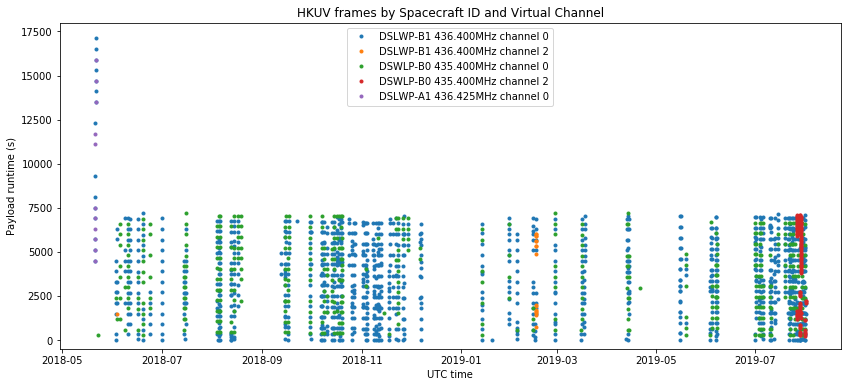

In [10]:
plt.figure(figsize = (14, 6), facecolor = 'w')
for chan in tlm_channels:
    t, x = get_tlm_variable(chan, 'runtime')
    plt.plot(t, x, '.', label = f'{spacecrafts[chan[0]]} channel {chan[1]}')
plt.ylim([-500,18000])
plt.legend()
plt.title('HKUV frames by Spacecraft ID and Virtual Channel')
plt.xlabel('UTC time')
plt.ylabel('Payload runtime (s)');

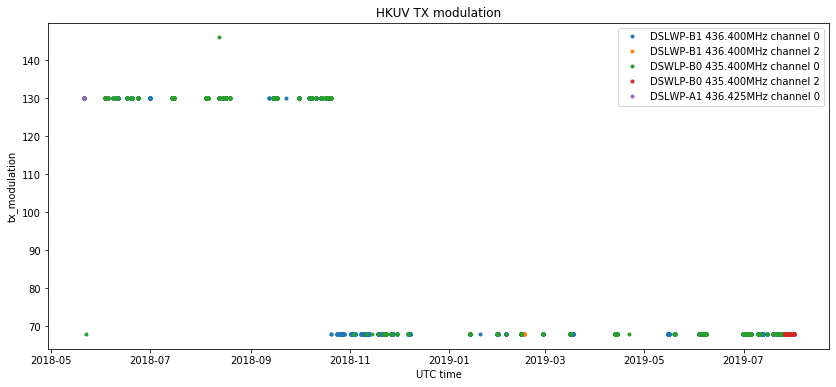

In [11]:
plt.figure(figsize = (14, 6), facecolor = 'w')
for chan in tlm_channels:
    t, x = get_tlm_variable(chan, 'tx_modulation')
    plt.plot(t, x, '.', label = f'{spacecrafts[chan[0]]} channel {chan[1]}')
plt.legend()
plt.title('HKUV TX modulation')
plt.ylabel('tx_modulation')
plt.xlabel('UTC time');

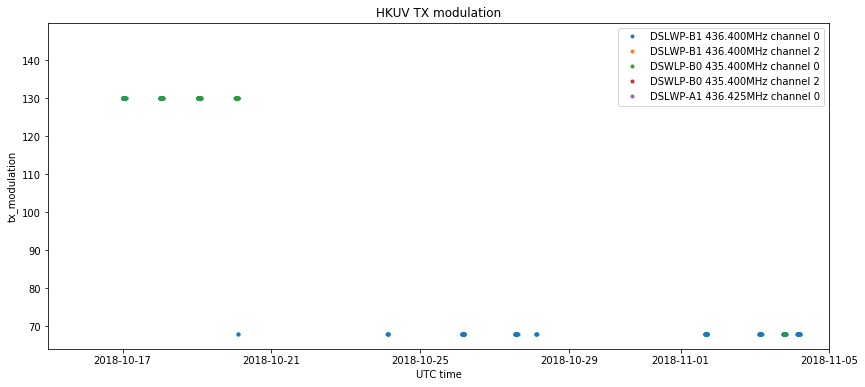

In [12]:
plt.figure(figsize = (14, 6), facecolor = 'w')
for chan in tlm_channels:
    t, x = get_tlm_variable(chan, 'tx_modulation')
    plt.plot(t, x, '.', label = f'{spacecrafts[chan[0]]} channel {chan[1]}')
plt.legend()
plt.xlim([np.datetime64('2018-10-15'), np.datetime64('2018-11-05')])
plt.title('HKUV TX modulation')
plt.ylabel('tx_modulation')
plt.xlabel('UTC time');

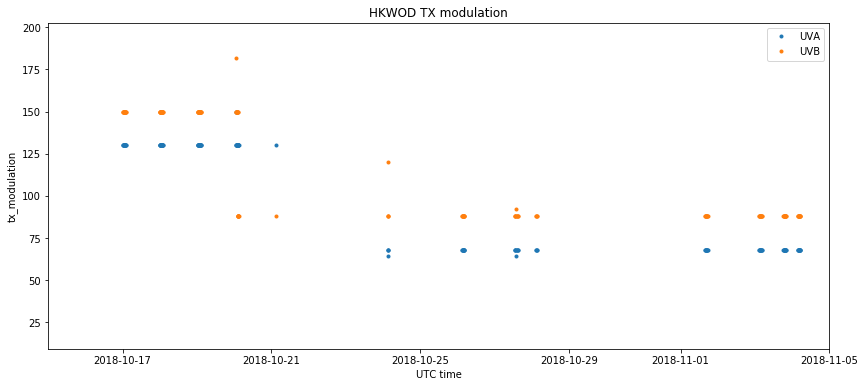

In [13]:
plt.figure(figsize = (14, 6), facecolor = 'w')
for chan in tlm_channels:
    t, x = get_tlm_variable(chan, 'uva_tx_modulation')
    plt.plot(t, x, '.', label = f'UVA {spacecrafts[chan[0]]} channel {chan[1]}', color = 'C0')
    t, x = get_tlm_variable(chan, 'uvb_tx_modulation')
    plt.plot(t, np.array(x) + 20, '.', label = f'UVB {spacecrafts[chan[0]]} channel {chan[1]}', color = 'C1')
plt.legend(['UVA', 'UVB'])
plt.xlim([np.datetime64('2018-10-15'), np.datetime64('2018-11-05')])
plt.title('HKWOD TX modulation')
plt.ylabel('tx_modulation')
plt.xlabel('UTC time');

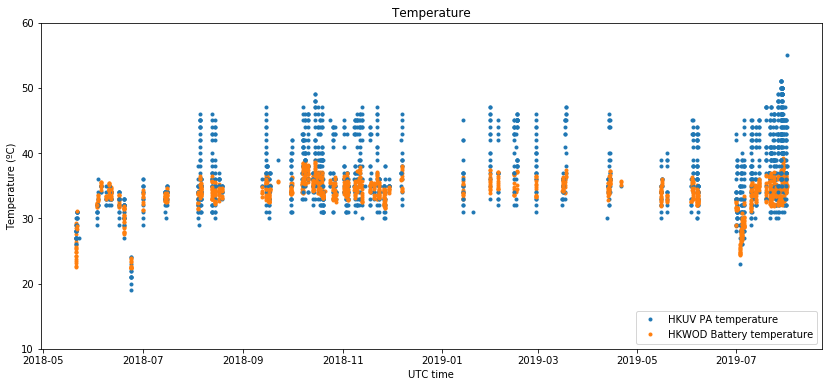

In [14]:
plt.figure(figsize = (14, 6), facecolor = 'w')
for chan in tlm_channels:
    t, x = get_tlm_variable(chan, 't_pa')
    plt.plot(t, x, '.', color = 'C0')
    t, x = get_tlm_variable(chan, 't_battery')
    plt.plot(t, x, '.', color = 'C1')
plt.ylim([10,60])
plt.title('Temperature')
plt.ylabel('Temperature (ºC)')
plt.xlabel('UTC time')
plt.legend(['HKUV PA temperature', 'HKWOD Battery temperature']);